In [64]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import pickle
from sklearn.preprocessing import scale
from torch.utils.data import DataLoader, Dataset, TensorDataset
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
train_features=torch.load('/content/drive/MyDrive/Colab Notebooks/KaggleProject/Code/train_features.pt')
train_labels=torch.load('/content/drive/MyDrive/Colab Notebooks/KaggleProject/Code/train_labels.pt')
print(train_features.shape)
print(train_labels.shape)

train = torch.cat([train_features, train_labels.reshape(-1,1)],1)
print(train.shape)
train = train[torch.randperm(train.size(0))] #shuffling dataset, parameter down need to be updated
train_set = train[0:1500000,                            0:train.shape[1]-1]
train_label = train[0:1500000,                          train.shape[1]-1]
validation_set = train[1500000:1600000,                 0:train.shape[1]-1]
validation_label = train[1500000:1600000,               train.shape[1]-1]
test_set = train[1600000:train.shape[0],                0:train.shape[1]-1]
test_label = train[1600000:train.shape[0],              train.shape[1]-1]

train_cache = '/content/drive/MyDrive/Colab Notebooks/KaggleProject/Cache/train.pickle'
train_labels_cache = '/content/drive/MyDrive/Colab Notebooks/KaggleProject/Cache/train-labels.npy'
validation_cache = '/content/drive/MyDrive/Colab Notebooks/KaggleProject/Cache/validation.pickle'
validation_labels_cache = '/content/drive/MyDrive/Colab Notebooks/KaggleProject/Cache/validation-labels.npy'
test_cache = '/content/drive/MyDrive/Colab Notebooks/KaggleProject/Cache/test.pickle'
test_labels_cache = '/content/drive/MyDrive/Colab Notebooks/KaggleProject/Cache/test-labels.npy'
competition_test_cache = '/content/drive/MyDrive/Colab Notebooks/KaggleProject/Cache/competition-test.pickle'
metadata_cache = '/content/drive/MyDrive/Colab Notebooks/KaggleProject/Cache/metadata.pickle'



torch.Size([1704759, 14])
torch.Size([1704759])
torch.Size([1704759, 15])


In [66]:
train_cache = '/content/drive/MyDrive/Colab Notebooks/KaggleProject/Cache/train2.pickle'
train_labels_cache = '/content/drive/MyDrive/Colab Notebooks/KaggleProject/Cache/train-labels2.npy'
validation_cache = '/content/drive/MyDrive/Colab Notebooks/KaggleProject/Cache/validation2.pickle'
validation_labels_cache = '/content/drive/MyDrive/Colab Notebooks/KaggleProject/Cache/validation-labels2.npy'
test_cache = '/content/drive/MyDrive/Colab Notebooks/KaggleProject/Cache/test2.pickle'
test_labels_cache = '/content/drive/MyDrive/Colab Notebooks/KaggleProject/Cache/test-labels2.npy'
competition_test_cache = '/content/drive/MyDrive/Colab Notebooks/KaggleProject/Cache/competition-test2.pickle'
metadata_cache = '/content/drive/MyDrive/Colab Notebooks/KaggleProject/Cache/metadata2.pickle'

train = pd.read_pickle(train_cache)
validation = pd.read_pickle(validation_cache)
test = pd.read_pickle(test_cache)

train_labels = np.load(train_labels_cache)
validation_labels = np.load(validation_labels_cache)
test_labels = np.load(test_labels_cache)

competition_test = pd.read_pickle(competition_test_cache)
with open(metadata_cache, 'rb') as handle:
    metadata = pickle.load(handle)

In [67]:
def process_features(df):
    return torch.tensor(df[['QUARTER_HOUR','DAY_OF_WEEK','WEEK_OF_YEAR','ORIGIN_CALL_ENCODED','TAXI_ID_ENCODED','ORIGIN_STAND_ENCODED',
                           'dt_2014-08-14 00:00:00','dt_2014-09-30 00:00:00','dt_2014-10-06 00:00:00','dt_2014-11-01 00:00:00',
                           'dt_2014-12-21 00:00:00']].values)

In [68]:
#Two layers got 726
#Three layers also 726
#200 epochs for >=300, three layers 708: 65, 100, 40, 10, 1
#88 epochs for 4 layers 679: 65, 160, 100, 50 15, 1
# class MLP(nn.Module):
#     def __init__(self):
#         super(MLP, self).__init__()
#         self.embed_quarter_hour = nn.Embedding(metadata['n_quarter_hours'], 10)
#         self.embed_day_of_week = nn.Embedding(metadata['n_days_per_week'], 10)
#         self.embed_week_of_year = nn.Embedding(metadata['n_weeks_per_year'],10)
#         self.embed_client_ids = nn.Embedding(metadata['n_client_ids'],10)
#         self.embed_taxi_ids = nn.Embedding(metadata['n_taxi_ids'],10)
#         self.embed_stand_ids = nn.Embedding(metadata['n_stand_ids'],10)
#         self.layer1 = nn.Sequential(
#             nn.Dropout(0.2),
#             nn.Linear(in_features=65, out_features=160),
#             nn.ReLU()
#         )
#         self.layer2 = nn.Sequential(
#             nn.Dropout(0.7),
#             nn.Linear(in_features = 160, out_features = 100),
#             nn.ReLU()
#         )
#         self.layer3 = nn.Sequential(
#             nn.Dropout(0.7),
#             nn.Linear(in_features = 100, out_features = 50),
#             nn.ReLU()
#         )
#         self.layer4 = nn.Sequential(
#             nn.Dropout(0.1),
#             nn.Linear(50,15),
#             nn.ReLU()
#         )
#         self.output_layer = nn.Linear(in_features=15, out_features=1)

#     def forward(self, x):
#         qhr = self.embed_quarter_hour(x[:,0].to(torch.int32))
#         dow = self.embed_day_of_week(x[:,1].to(torch.int32))
#         woy = self.embed_week_of_year(x[:,2].to(torch.int32))
#         ci = self.embed_client_ids(x[:,3].to(torch.int32))
#         ti = self.embed_taxi_ids(x[:,4].to(torch.int32))
#         si =  self.embed_stand_ids(x[:,5].to(torch.int32))
#         x = torch.cat([qhr,dow,woy,ci,ti,si,x[:,6:]],axis=1)
#         x = x.to(torch.float32)
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
#         x = self.output_layer(x)
#         return x

class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, nhead, drop_prob=0.7):
        super(TransformerModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.transformer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer, num_layers=n_layers)
        self.decoder = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x)
        return x



feature_size = 11  # your input feature size
hidden_dim = 712  # hidden dimensions
num_layers = 12  # number of transformer layers

# model = MLP(train_set.shape[1])
model = TransformerModel(input_dim=11, hidden_dim=hidden_dim, output_dim=1, n_layers=num_layers, nhead=2)


# Ensure the model is on the correct device and in the correct dtype
model = model.to(device).float()

In [69]:
import torch.optim as optim
learning_rate = 0.0001
criterion = nn.MSELoss()
num_epochs = 10
BATCH_SIZE = 40

In [70]:
x=process_features(train)
x.shape
train_data = process_features(train)
train_data = TensorDataset(train_data.float(), torch.tensor(train_labels).float())

validate_data = process_features(validation)
validate_data = TensorDataset(validate_data.float(), torch.tensor(validation_labels).float())

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validate_data, batch_size = BATCH_SIZE,shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
all_losses = []
train_loss = []
validation_losses = []

In [71]:
# model = MLP()
# model = model.to(device)

In [72]:
num_params = sum(param.numel() for param in model.parameters())
print(num_params)

64392849


In [73]:
# for name, module in model.named_modules():
#      print(name, sum(param.numel() for param in module.parameters()))

In [74]:
def validate(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    num_samples = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            num_samples += inputs.size(0)

    average_loss = total_loss / num_samples
    return average_loss


In [75]:
def train_data(model, train_loader, val_loader, criterion, num_epochs):
    optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, weight_decay = 1e-5, )
    for epoch in range(num_epochs):
        # Training Phase 
        model.train()
        epoch_loss = 0
        for i,(x, y) in enumerate(train_loader,0):
            x = x.to(device)
            y = y.to(device).to(torch.float32)
            y = torch.reshape(y,(-1,1))
            optimizer.zero_grad()
            output = model(x)
            loss = torch.sqrt(criterion(output, y))#RMSE
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        all_losses.append(epoch_loss/len(train_loader))
        print(f"Epoch: {epoch} Training Loss:{epoch_loss/len(train_loader)}")

        # Validation Phase
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_val = torch.reshape(y_val,(-1,1))
                preds = model(x_val)
                val_loss += torch.sqrt(criterion(preds, y_val)).item() # RMSE
        validation_losses.append(val_loss/len(val_loader))
        print(f"Epoch: {epoch} Validation Loss:{val_loss/len(val_loader)}")
        PATH = f'/content/drive/MyDrive/Colab Notebooks/KaggleProject/model_state/model_moreunit_epoch{epoch}.pth'     
        torch.save(model.state_dict(), PATH)

In [76]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/KaggleProject/model_state/model_epoch199.pth'))

In [77]:
num_epochs = 12
train_data(model, train_loader, val_loader, criterion, num_epochs=num_epochs) # use the training function you defined
val_loss = validate(model, val_loader, criterion)

Epoch: 0 Training Loss:740.4027807674006
Epoch: 0 Validation Loss:608.1773252941314
Epoch: 1 Training Loss:621.2361824805687
Epoch: 1 Validation Loss:609.5297593616303
Epoch: 2 Training Loss:621.0891735295581
Epoch: 2 Validation Loss:612.1915025256928
Epoch: 3 Training Loss:621.6627792552778
Epoch: 3 Validation Loss:605.2700998215448
Epoch: 4 Training Loss:620.6950644848687
Epoch: 4 Validation Loss:608.4588975452241
Epoch: 5 Training Loss:621.4889189044031
Epoch: 5 Validation Loss:603.9302317301432
Epoch: 6 Training Loss:621.3363806011045
Epoch: 6 Validation Loss:623.4235447474888
Epoch: 7 Training Loss:620.5991566390281
Epoch: 7 Validation Loss:608.7808903285435
Epoch: 8 Training Loss:620.8880783821191
Epoch: 8 Validation Loss:611.5582972935268
Epoch: 9 Training Loss:620.6954454854679
Epoch: 9 Validation Loss:610.7833706083752
Epoch: 10 Training Loss:621.5692887836551
Epoch: 10 Validation Loss:608.3072538829986
Epoch: 11 Training Loss:621.1126937081217
Epoch: 11 Validation Loss:613.93

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


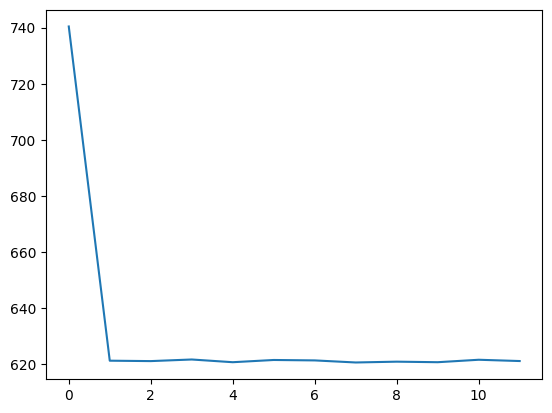

In [78]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(torch.Tensor.cpu(torch.tensor(all_losses)))

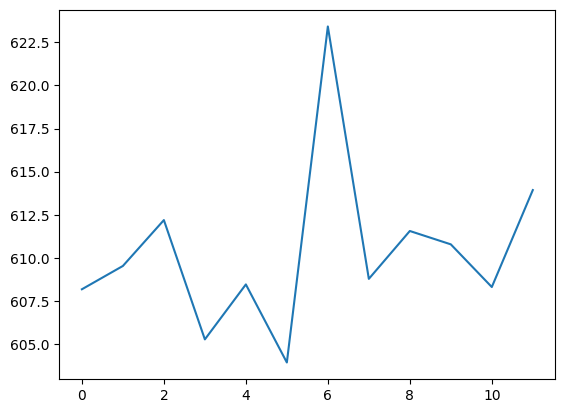

In [79]:
plt.figure()
plt.plot(torch.Tensor.cpu(torch.tensor(validation_losses)))

In [80]:
def view_loss(model, test_set, test_label,criterion):
    total_loss=0
    test_dataset = TensorDataset(test_set, test_label)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        y = torch.reshape(y,(-1,1))
        output = model(x)
        loss = torch.sqrt(criterion(output, y))#RMSE
        total_loss += loss
    return total_loss

In [81]:
# test_losses = []
# for i in range(100):
#     model.load_state_dict(torch.load(f'/content/drive/MyDrive/Colab Notebooks/KaggleProject/model_state/model_moreunit_epoch{i}.pth'))
#     test_losses.append(view_loss(model,process_features(test),torch.tensor(test_labels).to(torch.float32),criterion)/process_features(test).shape[0]*128)
#     print(f"epoch: {i}, test loss: {view_loss(model, process_features(test), torch.tensor(test_labels).to(torch.float32), criterion)/process_features(test).shape[0]*128}")


# min(test_losses)
# plt.figure()
# plt.plot(torch.Tensor.cpu(torch.tensor(test_losses)))

In [82]:
# print(model)

In [83]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/KaggleProject/model_state/model_moreunit_epoch90.pth'))

In [84]:
predict_input = torch.tensor(process_features(competition_test)).to(device)
predict_input = predict_input.to(torch.float32)

print(predict_input.shape)

def predict(model):
    predict_output = model(predict_input)
    return predict_output
out = predict(model)

torch.Size([320, 11])


<ipython-input-84-3f526b00d585>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predict_input = torch.tensor(process_features(competition_test)).to(device)


In [85]:
embed_mlp_predict = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KaggleProject/Code/test_public.csv')
embed_mlp_predict = embed_mlp_predict['TRIP_ID']
predict_tensor = out.to('cpu').detach().numpy().flatten()
embed_mlp_predict= pd.concat([embed_mlp_predict, pd.DataFrame(predict_tensor)], axis=1)
embed_mlp_predict = embed_mlp_predict.rename(columns={0: 'TRAVEL_TIME'})
embed_mlp_predict[0:50]

,TRIP_ID,TRAVEL_TIME
0,T1,843.004395
1,T2,843.004395
2,T3,843.004272
3,T4,843.004272
4,T5,843.004272
5,T6,843.004333
6,T7,843.004333
7,T8,843.004272
8,T9,843.004333
9,T10,843.004395


In [86]:
embed_mlp_predict['TRAVEL_TIME'].mean()

843.0043

In [87]:
# embed_mlp_predict.to_csv('Embedding_MLP_moreunit_89.csv', index=False)
embed_mlp_predict.to_csv('transformer_truncated.csv', index=False)

In [88]:
a = process_features(train)
print(a[:,0])
embedding1 = torch.nn.Embedding(96, 10)
# embedding2 = torch.nn.Embedding()
print(embedding1(a[0,0].to(torch.int32)))

tensor([70., 72., 79.,  ..., 37., 34., 35.], dtype=torch.float64)
tensor([-0.5682, -0.7456, -1.6795, -0.9134, -0.0373,  0.9635, -0.4594, -0.2946,
         1.2522,  1.2046], grad_fn=<EmbeddingBackward0>)
